# Deep Solaris Notebook for Automatic Filtering of  PDOK Dop25 data and NRW Dop20 data.

OWSLIB is a library that allows to deal with the WMS protocol that is an automated protocol to download geoTIFF images from HTTP services published online. <br>
This notebook shows how to download and filter dop20 and dop25 images from Germany and the Netherlands. <br>



First of all there are a set of WMS services that allow us to simply query an HTTP link and get a map
From an area, provided that we know the gps coordinates of an area.
the most prominent WMS service from the Netherlands is PDOK and it allows to query with a 25cm per pixel
and it allows for both RGB and Infrarred
 
The link for RGB:
https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wms?&request=GetCapabilities<BR>
The link for Infrared:
https://geodata.nationaalgeoregister.nl/luchtfoto/infrarood/wms?&request=GetCapabilities<BR>

The Netherlands register allows also to query by year, with a maximum 5 years period, which may allow
reasoning of multiple types concerning the map.

The link for NRW (North Rhine Westphalia) provides both RGB and Infrared possibilities in the layers that can
be directly queried in the http service
https://www.wms.nrw.de/geobasis/wms_nw_dop


Below we proceed with an analysis of the data for NRW and the Netherlands.

The code for this report has an illustrative purpose, therefore code repetitions
may happen to simplify the discussion.


# North Rhine Westphalia Analysis

In [1]:
from owslib.wms import WebMapService

wms = WebMapService('https://www.wms.nrw.de/geobasis/wms_nw_dop', version='1.1.1')


In [2]:
print(list(wms.contents))

print(wms['nw_dop_rgb'].boundingBox)
print( wms['nw_dop_rgb'].styles)
print(wms['nw_dop_rgb'].boundingBoxWGS84)
print( wms['nw_dop_rgb'].crsOptions)

#EPSG:4326 is the one we want because it is a gps system.


['WMS_NW_DOP', 'nw_dop_utm_info', 'nw_dop_rgb', 'nw_dop_cir', 'nw_dop_nir']
(270100.0, 5550000.0, 550000.0, 5850000.0, 'EPSG:25832')
{'default': {'title': 'default', 'legend': 'https://www.wms.nrw.de/geobasis/wms_nw_dop?request=GetLegendGraphic&format=image/png&layer=keine_legende'}}
(5.59334, 50.0578, 9.74158, 52.7998)
['EPSG:25831', 'EPSG:5649', 'EPSG:3044', 'EPSG:5652', 'EPSG:3045', 'EPSG:5653', 'EPSG:3035', 'EPSG:4326', 'EPSG:4258', 'EPSG:28992', 'EPSG:31467', 'EPSG:25832', 'EPSG:5651', 'EPSG:31466', 'EPSG:3857', 'EPSG:3034', 'EPSG:4647', 'EPSG:25833', 'EPSG:5650', 'EPSG:3043']


In [3]:
print([op.name for op in wms.operations])
print(wms.getOperationByName('GetMap').methods)
print(wms.getOperationByName('GetMap').formatOptions)


['GetCapabilities', 'GetMap', 'GetFeatureInfo', 'DescribeLayer', 'GetLegendGraphic', 'GetStyles']
[{'type': 'Get', 'url': 'https://www.wms.nrw.de/geobasis/wms_nw_dop?'}, {'type': 'Post', 'url': 'https://www.wms.nrw.de/geobasis/wms_nw_dop?'}]
['image/png', 'image/jpeg', 'image/png; mode=8bit', 'image/tiff', 'application/vnd.google-earth.kml+xml', 'application/vnd.google-earth.kmz']


In [4]:
# this prints the whole NRW in a 300, 250 image, just to see that we are in the right place.
img = wms.getmap(   layers=['nw_dop_rgb'], styles=['default'], srs='EPSG:4326',
                bbox=(5.59334, 50.0578, 9.74158, 52.7998), 
                 size=(300, 250), format='image/jpeg', transparent=True)


In [5]:
#plt.imshow(img.read())
#plt.show()

out = open('attempt2.jpg', 'wb')
out.write(img.read())
out.close()

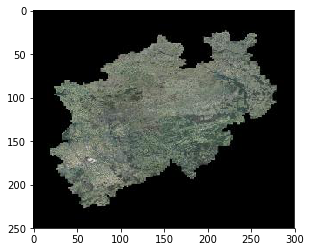

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgl=mpimg.imread('attempt2.jpg')
imgplot = plt.imshow(imgl)

plt.show() #there you go.

## Interesting longitudes and latitudes for the project in NRW

Aachen: center = (6.08342,50.77664) <BR> 
Bonn: bonn_center=(7.0982, 50.7374) <BR>
Essen:  essen_center=(7.0116, 51.4556) <BR>
Dortmund: dortmun_center=(7.4653,51.5136) <BR>
Duisburg: duisburg_center=(6.7623,51.4344) <BR>
Monschau: monschau_center= (6.256389,50.56) <BR>
Bochum: center = (7.216236, 51.481846) <BR>
koln residential area: center = (7.060243,50.882887) <BR>
Dusseldorf: center = (6.77616,51.22172) <BR>

simply use them below, by changing loc.

Below epsg:4326 allows to specify the GPS coordinates
while epsg:3857 allows to specify things in meters.


In [8]:
from pyproj import Proj, transform


center= (6.7623,51.4344) #(6.77616,51.22172) 
#(7.0982, 50.7374) #(7.216236, 51.481846)
#(6.256389,50.56)#(6.7623,51.4344) #(7.4653,51.5136)#(7.0116, 51.4556)#(6.0839,50.7753)
loc = center


In [12]:
#Like the code above, but as a function.
from pyproj import Proj, transform

#Remember that to avoid an overlap one has to take x2 the size of the image for the sliding.
def slide_location(loc,xmeters,ymeters,xtimes,ytimes):
    outProj = Proj(init='epsg:3857') # https://epsg.io/3857, basically it allows me to specify things in meters..
    inProj = Proj(init='epsg:4326') # https://epsg.io/4326
    x, y = transform(inProj,outProj,loc[0],loc[1])
    locs = []
    #in GPS
    #locs.append(loc)
    for i in range(xtimes):
        for j in range(ytimes):
            x = x + xmeters*i
            y = y + ymeters*j
            x_gps,y_gps=transform(outProj,inProj,x,y)
            loc = (x_gps,y_gps)
            locs.append(loc)
    return locs

#checking manually the behaviour of slide location, city center of aachen

locs=slide_location((6.08342,50.77664), xmeters=2000,ymeters=2000,xtimes=3,ytimes=3) 
#should provi
print(locs)


def img_selector(wms,layer,img_format,loc, styles=None , x_meters=1000,y_meters=1000, x_pixels=5000,y_pixels =5000):
    outProj = Proj(init='epsg:3857') # https://epsg.io/3857, basically it allows me to specify things in meters..
    inProj = Proj(init='epsg:4326') # https://epsg.io/4326
    x, y = transform(inProj,outProj,loc[0],loc[1])
    region_size = (x_meters, y_meters)
    xupper = int(round(x - region_size[0] / 2))
    xlower = int(round(x + region_size[0] / 2))
    yupper = int(round(y - region_size[1] / 2))
    ylower = int(round(y + region_size[1] / 2))
    bbox = (xupper, yupper, xlower, ylower)
    if not styles==None:
        img = wms.getmap(layers=[layer], styles=['default'], srs='EPSG:3857',
                     bbox=bbox, 
                     size=(x_pixels, y_pixels), format=img_format, transparent=True)
    else:
        img = wms.getmap(layers=[layer], srs='EPSG:3857',
                     bbox=bbox, 
                     size=(x_pixels, y_pixels), format=img_format, transparent=True)
    return img


[(6.083419999999989, 50.77663999999999), (6.083419999999989, 50.78799952733883), (6.083419999999989, 50.81071030355695), (6.101386305682379, 50.81071030355695), (6.11935261136477, 50.8220615528852), (6.1373189170471605, 50.84475577510537), (6.173251528411941, 50.84475577510537), (6.209184139776722, 50.85609874844854), (6.245116751141503, 50.87877642073195)]


In [14]:
import io
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import traceback

layer = 'nw_dop_rgb'
img_format = "image/tiff"
style='default'

locs = slide_location(loc,xmeters=2000,ymeters=2000,xtimes=4,ytimes=4)

images = []
for loc in locs:
    img = img_selector(wms,layer,img_format,loc, styles=style , x_meters=1000,y_meters=1000, x_pixels=5000,y_pixels =5000)
    mybyteimg = img.read()
    image = Image.open(io.BytesIO(mybyteimg))
    images.append(image)

KeyboardInterrupt: 

In [15]:
name = "center_duisburg"
for i in range(len(images)):
    images[i].save(name+"_"+str(i)+".tiff")
    #out = open(, 'wb')
    #out.write(images[i].tobytes())
    #out.close()

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [23]:
images = []

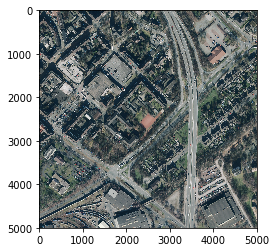

In [24]:
image_name='center_duisburg_3'

imgl=mpimg.imread(image_name + ".tiff")# for the moment I select manually
imgplot = plt.imshow(imgl)

plt.show() #there you go.

## Splitting the image in tiles of MxN pixels.

we selected a 75x75 image size because it roughly correspond to 14 (dop20) to 21 (dop25) meters, that typically comprises the dimension of a roof/building.

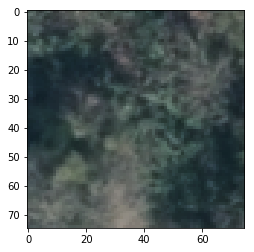

In [19]:
import cv2 

M = 75
N = 75
tiles = [imgl[x:x+M,y:y+N] for x in range(0,imgl.shape[0],M) for y in range(0,imgl.shape[1],N)]

for i in range(0,len(tiles)):
    tiles[i]=cv2.cvtColor(tiles[i], cv2.COLOR_RGBA2RGB)

plt.imshow(tiles[0])

plt.show() #there you go.

# Filtering using a neural network trained on a seed data set of NRW.

In [20]:
#code to set tensorflow backend

!set "KERAS_BACKEND=tensorflow"


import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras; import keras.backend
if keras.backend.backend() != 'tensorflow':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('tf')
    print("Backend ok")

Using TensorFlow backend.


Backend ok


In [21]:
import models
from keras.optimizers import Adam

model = models.fft_vgg(2) #this creates a feature extractor for VGG...

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
model.summary()

model.load_weights("fft_vgg.npy")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FFT_IN (FFT_IN)              (None, 75, 75, 3)         16875     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
__________

In [22]:
import numpy as np
from PIL import Image
import traceback


count = 0
for tile in tiles:
    try:
        
        prediction = model.predict(np.expand_dims(tile/255,axis=0))
        #print(prediction)
        predicted_class =np.argmax(prediction)
    
        if predicted_class ==0:
        
            myimg = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
            cv2.imwrite("./predictions/neg/" + image_name+ "_img_"+str(count)+".png",myimg)
          
        
        if predicted_class ==1:
            
            myimg = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
            cv2.imwrite("./predictions/pos/" + image_name+ "_img_"+str(count)+".png",myimg)
          
            
        count+=1
    except: 
        #print("shape")
        traceback.print_exc()
        print(tile.shape)

Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)


(75, 50, 3)
(75, 50, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 75, 3)
(50, 50, 3)


Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 754, in _standardize_user_data
    exception_prefix='input')
  File "D:\Anaconda3\lib\site-packages\keras\engine\training_utils.py", line 136, in standardize_input_data
    str(data_shape))
ValueError: Error when checking input: expected FFT_IN_input to have shape (75, 75, 3) but got array with shape (75, 50, 3)
Traceback (most recent call last):
  File "<ipython-input-22-b749f19e2d57>", line 10, in <module>
    prediction = model.predict(np.expand_dims(tile/255,axis=0))
  File "D:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1152, in predict
    x, _, _ = self._standardize_user_data(x)
  File "D:\Anaconda3\lib\

In [ ]:
tiles[0]

In [ ]:
myimg = cv2.cvtColor(tiles[0], cv2.COLOR_BGRA2RGB)

cv2.imwrite("attempt0.png",myimg)

# PDOK, Netherlands Analysis

In [ ]:
# https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wms?&request=GetCapabilities

from owslib.wms import WebMapService

wms = WebMapService('https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wms?&request=GetCapabilities', version='1.1.1')


In [38]:
#it already provides the evolution in time of the image
print(list(wms.contents)) 

print(wms['Actueel_ortho25'].boundingBox)
print( wms['Actueel_ortho25'].styles)
print(wms['Actueel_ortho25'].boundingBoxWGS84)
print( wms['Actueel_ortho25'].crsOptions)

print([op.name for op in wms.operations])
print(wms.getOperationByName('GetMap').methods)
print(wms.getOperationByName('GetMap').formatOptions)

['2016_ortho25', '2017_ortho25', 'Actueel_ortho25']
(-1.65729160235, 48.0405018704, 12.4317272654, 56.1105896442, 'EPSG:4326')
{}
(-1.65729160235, 48.0405018704, 12.4317272654, 56.1105896442)
['EPSG:4326', 'EPSG:4258', 'EPSG:25832', 'EPSG:28992', 'EPSG:3857', 'EPSG:25831']
['GetCapabilities', 'GetMap', 'GetFeatureInfo']
[{'type': 'Get', 'url': 'https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wms?'}]
['image/png', 'image/jpeg', 'image/gif', 'image/GeoTIFF', 'image/tiff']


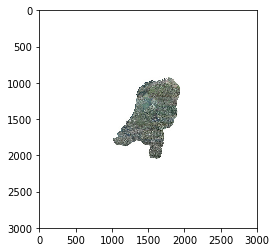

In [31]:
# this prints the whole Netherlands in a 300, 250 image, just to see that we are in the right place.
# notice that in this case there is no style available.

img = wms.getmap(layers=['Actueel_ortho25'], srs='EPSG:4326',  
                bbox=(-1.65729160235, 48.0405018704, 12.4317272654, 56.1105896442), 
                size=(3000, 3000), format='image/jpeg', transparent=True)

#plt.imshow(img.read())
#plt.show()

image_name = "netherlands.jpg"

out = open(image_name, 'wb')
out.write(img.read())
out.close()


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgl=mpimg.imread(image_name)
imgplot = plt.imshow(imgl)

plt.show() #Image of the Netherlands.

# Interesting centers for the netherlands 

Heerlen: center = (5.9794988,50.8881742)<BR>

In [ ]:
import io
import matplotlib.image as mpimg


loc = (5.9794988,50.8881742)
layer = 'Actueel_ortho25'
img_format = "image/tiff"


locs = slide_location(loc,xmeters=2500,ymeters=2500,xtimes=2,ytimes=2)

images = []
for loc in locs:
    img = img_selector(wms,layer,img_format,loc, styles=None , x_meters=1250,y_meters=1250, x_pixels=5000,y_pixles =5000)
    mybyteimg = img.read()
    image = Image.open(io.BytesIO(mybyteimg))
    images.append(image)

#img = img_selector(layer,img_format,loc, styles=None , x_meters=1250,y_meters=1250, x_pixels=5000,y_pixles =5000)

In [68]:
name = "center_heerlen"
for i in range(len(images)):
    images[i].save(name+"_"+str(i)+".tiff")
    #out = open(, 'wb')
    #out.write(images[i].tobytes())
    #out.close()

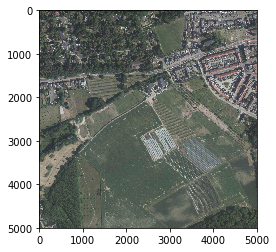

In [75]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


imgl=mpimg.imread('center_heerlen_2.tiff')
imgplot = plt.imshow(imgl)

plt.show() #there you go.

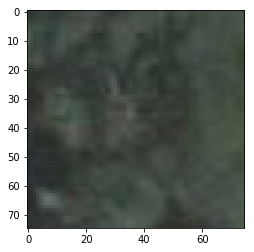

In [76]:
import cv2 

M = 75
N = 75
tiles = [imgl[x:x+M,y:y+N] for x in range(0,imgl.shape[0],M) for y in range(0,imgl.shape[1],N)]

for i in range(0,len(tiles)):
    tiles[i]=cv2.cvtColor(tiles[i], cv2.COLOR_RGBA2RGB)

plt.imshow(tiles[0])

plt.show() #there you go.

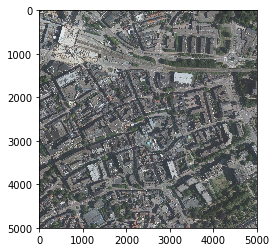

In [58]:
myimg =img.read()


from PIL import Image
import io

image = Image.open(io.BytesIO(myimg))

plt.imshow(image)
plt.show()


In [67]:
tiff= images[2]

type(mpimg.pil_to_array(tiff))



numpy.ndarray